train data -> N:51542, Y:7657 개

매년 전기 에너지 사용량 달별로 더해서 컬럼 12개로 압축

log 변환

Y,N 그룹 별 각 컬럼간 상관도 ->pairplot

Y,N 그룹 별 각 컬럼의 평균값 barplot

Y,N 그룹 별 각 컬럼의 분포도 box plot

Y,N 그룹 별 각 컬럼의 분포도 dist plot

Y,N 그룹 별 건물용도 별 각 컬럼의 분포도 boxplot

예측 - >  정확도: 0.8371, 정밀도: 0.8426, 재현율: 0.1431,    F1: 0.2446, AUC:0.5685
너무 쉽게 N으로 판단 -> N의 0값의 비중이 너무 큼 ->  Y의 0을 그냥 N으로 판단하는듯 -> 0부터 어떻게 해야함!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [3]:
def plot_mean(df_n):
    index = np.array(df_n.mean().index)
    height = np.array(df_n.mean())
    plt.figure(figsize=(16,10))
    plt.bar(index, height)
    
def plot_dist(df):
    list_series = df.columns
    n=len(list_series)
    plt.figure(figsize=(25,6))
    fig , axes = plt.subplots(n//2+1,2,figsize=(15,40))
    axx = axes.flatten()
    for index,i in enumerate(list_series[:-2]):
        x=df[i]
        sns.distplot(x, kde=True, rug=False,ax=axx[index])
    
def elec_month(df_y):
    df_y_local = df_y.drop(['label','bldng_us'],axis=1)
    for i in range(1,13):
        col = '{0} month'.format(i)
        df_y_local[col]=df_y_local.iloc[:,(i-1)::12].sum(axis=1)
    df_y_local = df_y_local.iloc[:,-1:-13:-1]
    df_y_local = df_y_local.iloc[:,-1:-13:-1]
    df_y_local['bldng_us']=df_y['bldng_us']
    df_y_local['label']=df_y['label']
    return df_y_local

def plot_box1(df,label):
    list_series = df.columns
    n=len(list_series)
    fig , axes = plt.subplots(4,n//4+1,figsize=(15,15))
    axx = axes.flatten()
    for index,i in enumerate(list_series[:-2]):
        sns.boxplot(i, label, data=df,ax=axx[index])
        #sns.stripplot(x, 'bldng_us',hue=label, data=df, jitter=True, color="0.4",ax=axx[index])

def plot_box2(df,label):
    list_series = df.columns
    n=len(list_series)
    fig , axes = plt.subplots(4,n//4+1,figsize=(15,150))
    axx = axes.flatten()
    for index,i in enumerate(list_series[:-2]):
        sns.boxplot(i, label,hue='bldng_us', data=df,ax=axx[index])
        #sns.stripplot(x, 'bldng_us',hue=label, data=df, jitter=True, color="0.4",ax=axx[index])
        
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['label']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

def fill_elec(df):
    list_ = list(df.columns[:-2])

    for i in list_:
        df[i].fillna(df.groupby('bldng_us')[i].mean(), inplace=True)
    return df

In [4]:
df = pd.read_csv("PJT002_train.csv")
df_vali = pd.read_csv('PJT002_validation.csv')
df.iloc[:,1].value_counts()
df.head(3)

C:\Users\jaeyong\Anaconda3\envs\cuda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8,172,173,174,175,176,177,178,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


dt_of_fr fr_yn bldng_us bldng_archtctr  bldng_cnt  bldng_ar  \
0  2017-10-20 05:54:00     Y     단독주택           블록구조          3     69.42   
1  2018-09-30 08:26:15     N      NaN            NaN          3     46.29   
2  2016-10-30 14:57:00     Y     공동주택       철근콘크리트구조          1    583.80   

    ttl_ar  lnd_ar dt_of_athrztn  ttl_grnd_flr  ...  no_tbc_zn_dstnc  \
0    69.42     0.0          1977           1.0  ...               88   
1    46.29     0.0           NaN           1.0  ...             7727   
2  2516.76  1446.0   2.00011e+07           5.0  ...               72   

  bldng_cnt_in_50m  trgt_crtr  fr_fghtng_fclt_spcl_css_5_yn  \
0                0        NaN                           NaN   
1                0        NaN                           NaN   
2               14        NaN                           NaN   

   fr_fghtng_fclt_spcl_css_6_yn  us_yn  dngrs_thng_yn  slf_fr_brgd_yn  \
0                           NaN    NaN            NaN             NaN   
1                           NaN    NaN            NaN             NaN   
2                           NaN    NaN            NaN             NaN   

   blk_dngrs_thng_mnfctr_yn  cltrl_hrtg_yn  
0                       NaN            NaN  
1                       NaN            NaN  
2                       NaN            NaN  

[3 rows x 180 columns]

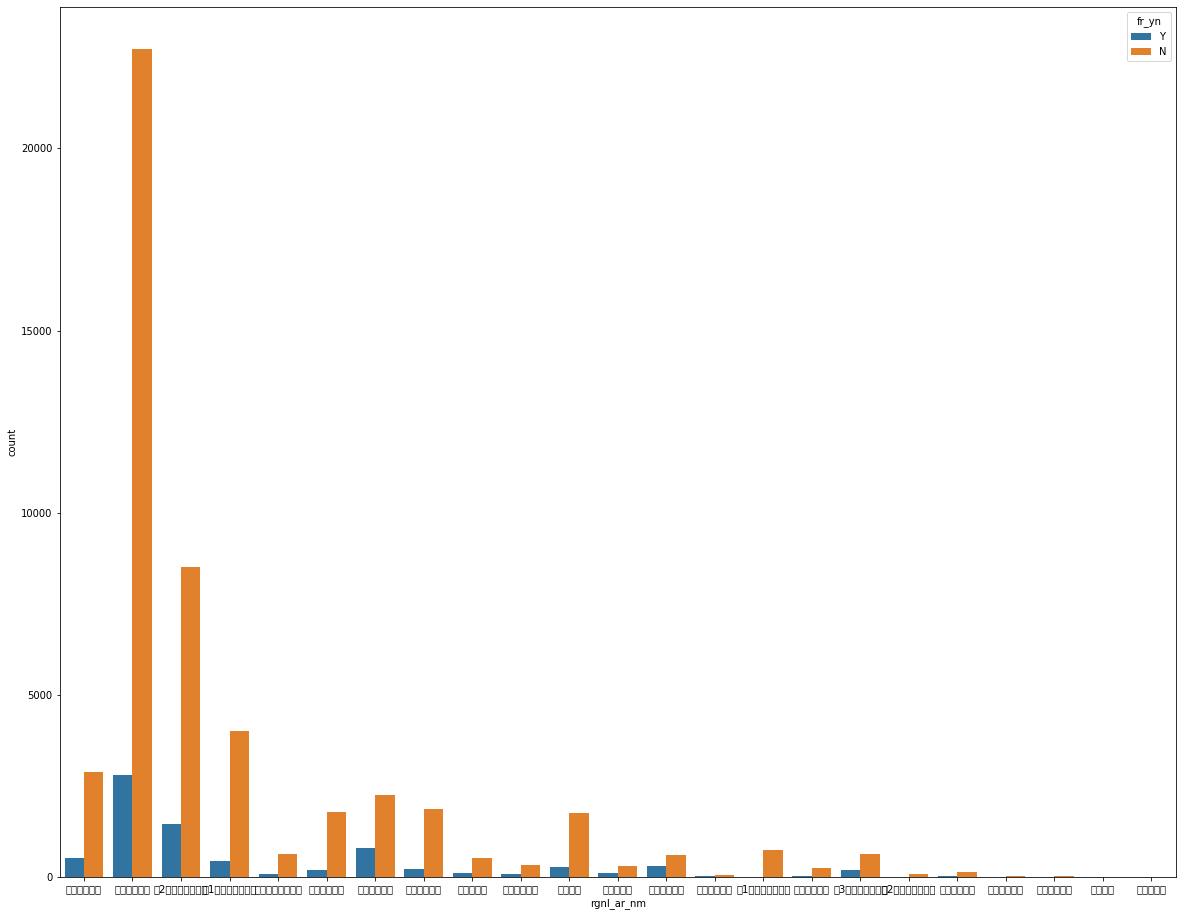

In [13]:
fig = plt.figure(figsize=(20,16))
sns.countplot('rgnl_ar_nm',data = df, hue = 'fr_yn')

In [ ]:
fig = plt.figure(figsize=(20,16))
sns.countplot('rgnl_ar_nm',data = df[df['fr_yn']=='Y'])

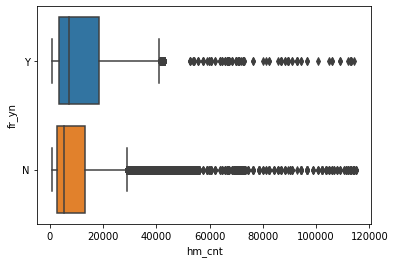

In [15]:
sns.boxplot('hm_cnt','fr_yn', data= df )

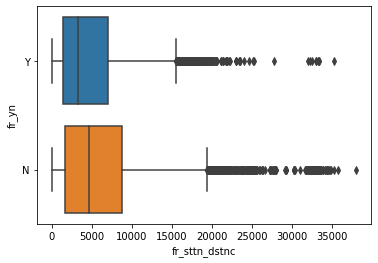

In [16]:
sns.boxplot('fr_sttn_dstnc','fr_yn', data= df )

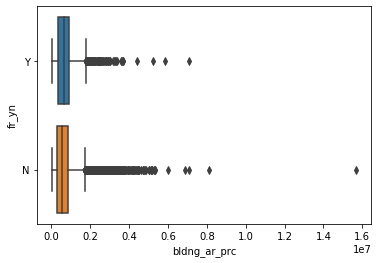

In [17]:
sns.boxplot('bldng_ar_prc','fr_yn', data= df )

In [15]:
df_elec = df.iloc[:,18:137:2]
col = df_elec.columns
for i in col:
    print('{0} 의 null 값 비율 : {1}'.format(i,df_elec[i].isna().sum()/df_elec.shape[0]))
df_elec = df_elec.dropna()
df_elec = df_elec.applymap(lambda x : np.log(1+x))

ele_engry_us_201401 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201402 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201403 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201404 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201405 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201406 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201407 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201408 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201409 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201410 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201411 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201412 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201501 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201502 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201503 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201504 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201505 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201506 의 null 값 비율 : 0.4659031402557476
ele_engry_us_201507 의 null 값 비율 : 0.4659031402

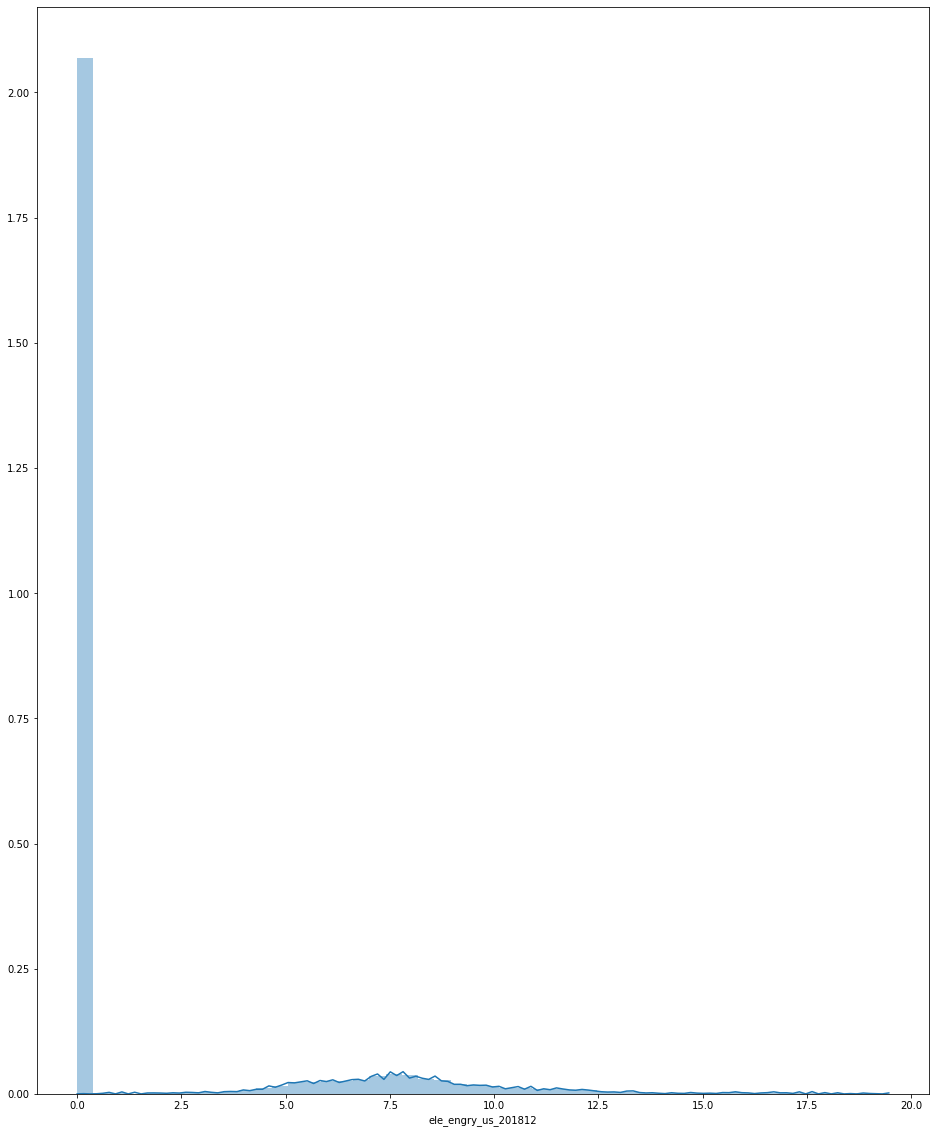

In [21]:
fig = plt.figure(figsize=(16,20))
sns.distplot(df_elec['ele_engry_us_201812'],kde=True, rug = False) 

In [10]:
df_elec['bldng_us']=df['bldng_us']
df_elec['bldng_us'].fillna('NaN', inplace=True)
df_elec['label']=df.iloc[:,1]
#df_elec['label']=df_elec['label'].apply(lambda x: 0 if x=='N' else 1)

In [11]:
encoder = LabelEncoder()
encoder.fit(df_elec['bldng_us'])
df_elec['bldng_us'] = encoder.transform(df_elec['bldng_us'])

In [13]:
df_month = elec_month(df_elec)

elec_mon_log = df_month.iloc[:,:-2].apply(lambda x: np.log10(1+x))
elec_mon_log['bldng_us']=df_month['bldng_us']
elec_mon_log['label']=df_month['label']
elec_mon_log.head()

1 month  2 month  3 month  4 month  5 month  6 month  7 month  8 month  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   9 month  10 month  11 month  12 month  bldng_us label  
0      0.0       0.0       0.0       0.0        10     Y  
1      0.0       0.0       0.0       0.0         0     N  
2      0.0       0.0       0.0       0.0         2     Y  
3      0.0       0.0       0.0       0.0        10     N  
4      0.0       0.0       0.0       0.0         0     N

In [15]:
df_y = elec_mon_log[elec_mon_log['label']=='Y']
df_n = elec_mon_log[elec_mon_log['label']=='N']
#df_gas = df.iloc[:,17:137:2]
#df_gas['label']=df.iloc[:,1]
#df_gas.

In [14]:
df_elec_vali = df_vali.iloc[:,17:137:2]
df_elec_vali['bldng_us']=df_vali['bldng_us']
df_elec_vali['label']=df_vali['fr_yn']
#df_elec_vali['label']=df_elec_vali['label'].apply(lambda x: 0 if x=='N' else 1)

df_month_vali = elec_month(df_elec_vali)

elec_mon_log_vali = df_month_vali.iloc[:,:-2].apply(lambda x: np.log10(1+x))
elec_mon_log_vali['bldng_us']=df_month_vali['bldng_us']
elec_mon_log_vali['label']=df_month_vali['label']
elec_mon_log_vali.head()

1 month   2 month   3 month   4 month  5 month   6 month   7 month  \
0  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
3  3.775028  3.802089  4.032699  4.071882  4.08803  4.152135  4.224533   
4  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   

    8 month  9 month  10 month  11 month  12 month bldng_us label  
0  0.000000   0.0000  0.000000  0.000000  0.000000     단독주택     N  
1  0.000000   0.0000  0.000000  0.000000  0.000000      NaN     N  
2  0.000000   0.0000  0.000000  0.000000  0.000000     단독주택     N  
3  4.301724   4.2173  4.141951  4.105374  4.088632       공장     Y  
4  0.000000   0.0000  0.000000  0.000000  0.000000     단독주택     N

In [11]:
df_y_vali = elec_mon_log_vali[elec_mon_log_vali['label']=="Y"]
df_n_vali = elec_mon_log_vali[elec_mon_log_vali['label']=="N"]

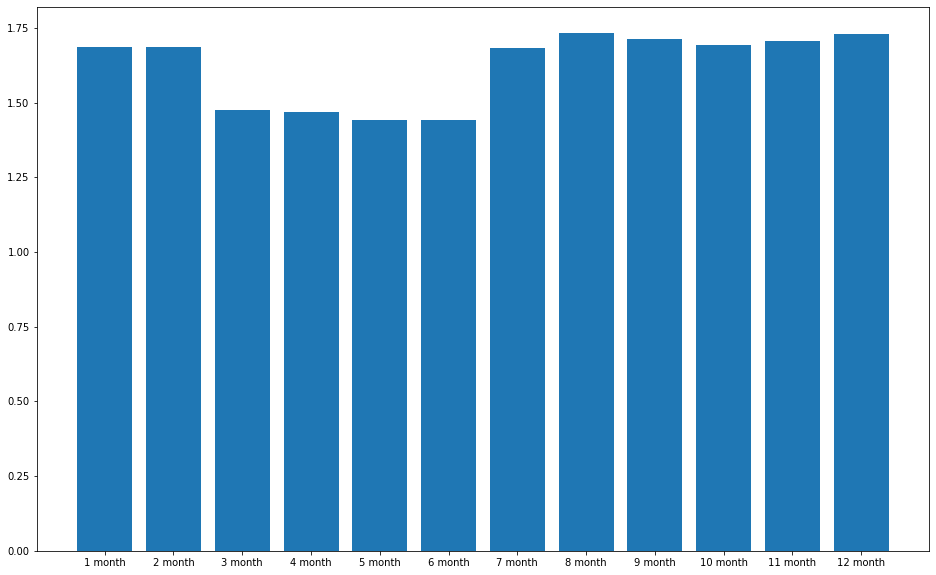

In [9]:
plot_mean(df_y.iloc[:,:-2])

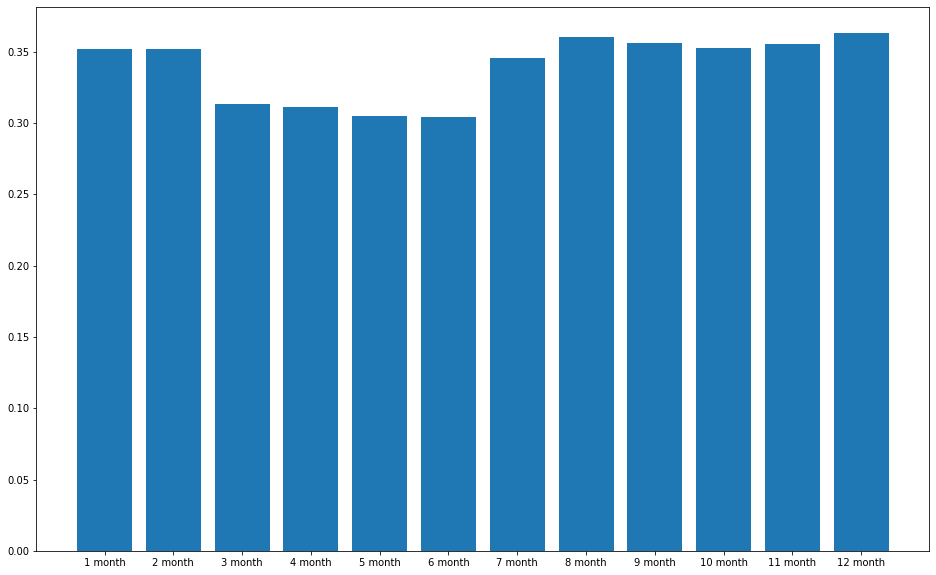

In [10]:
plot_mean(df_n.iloc[:,:-2])

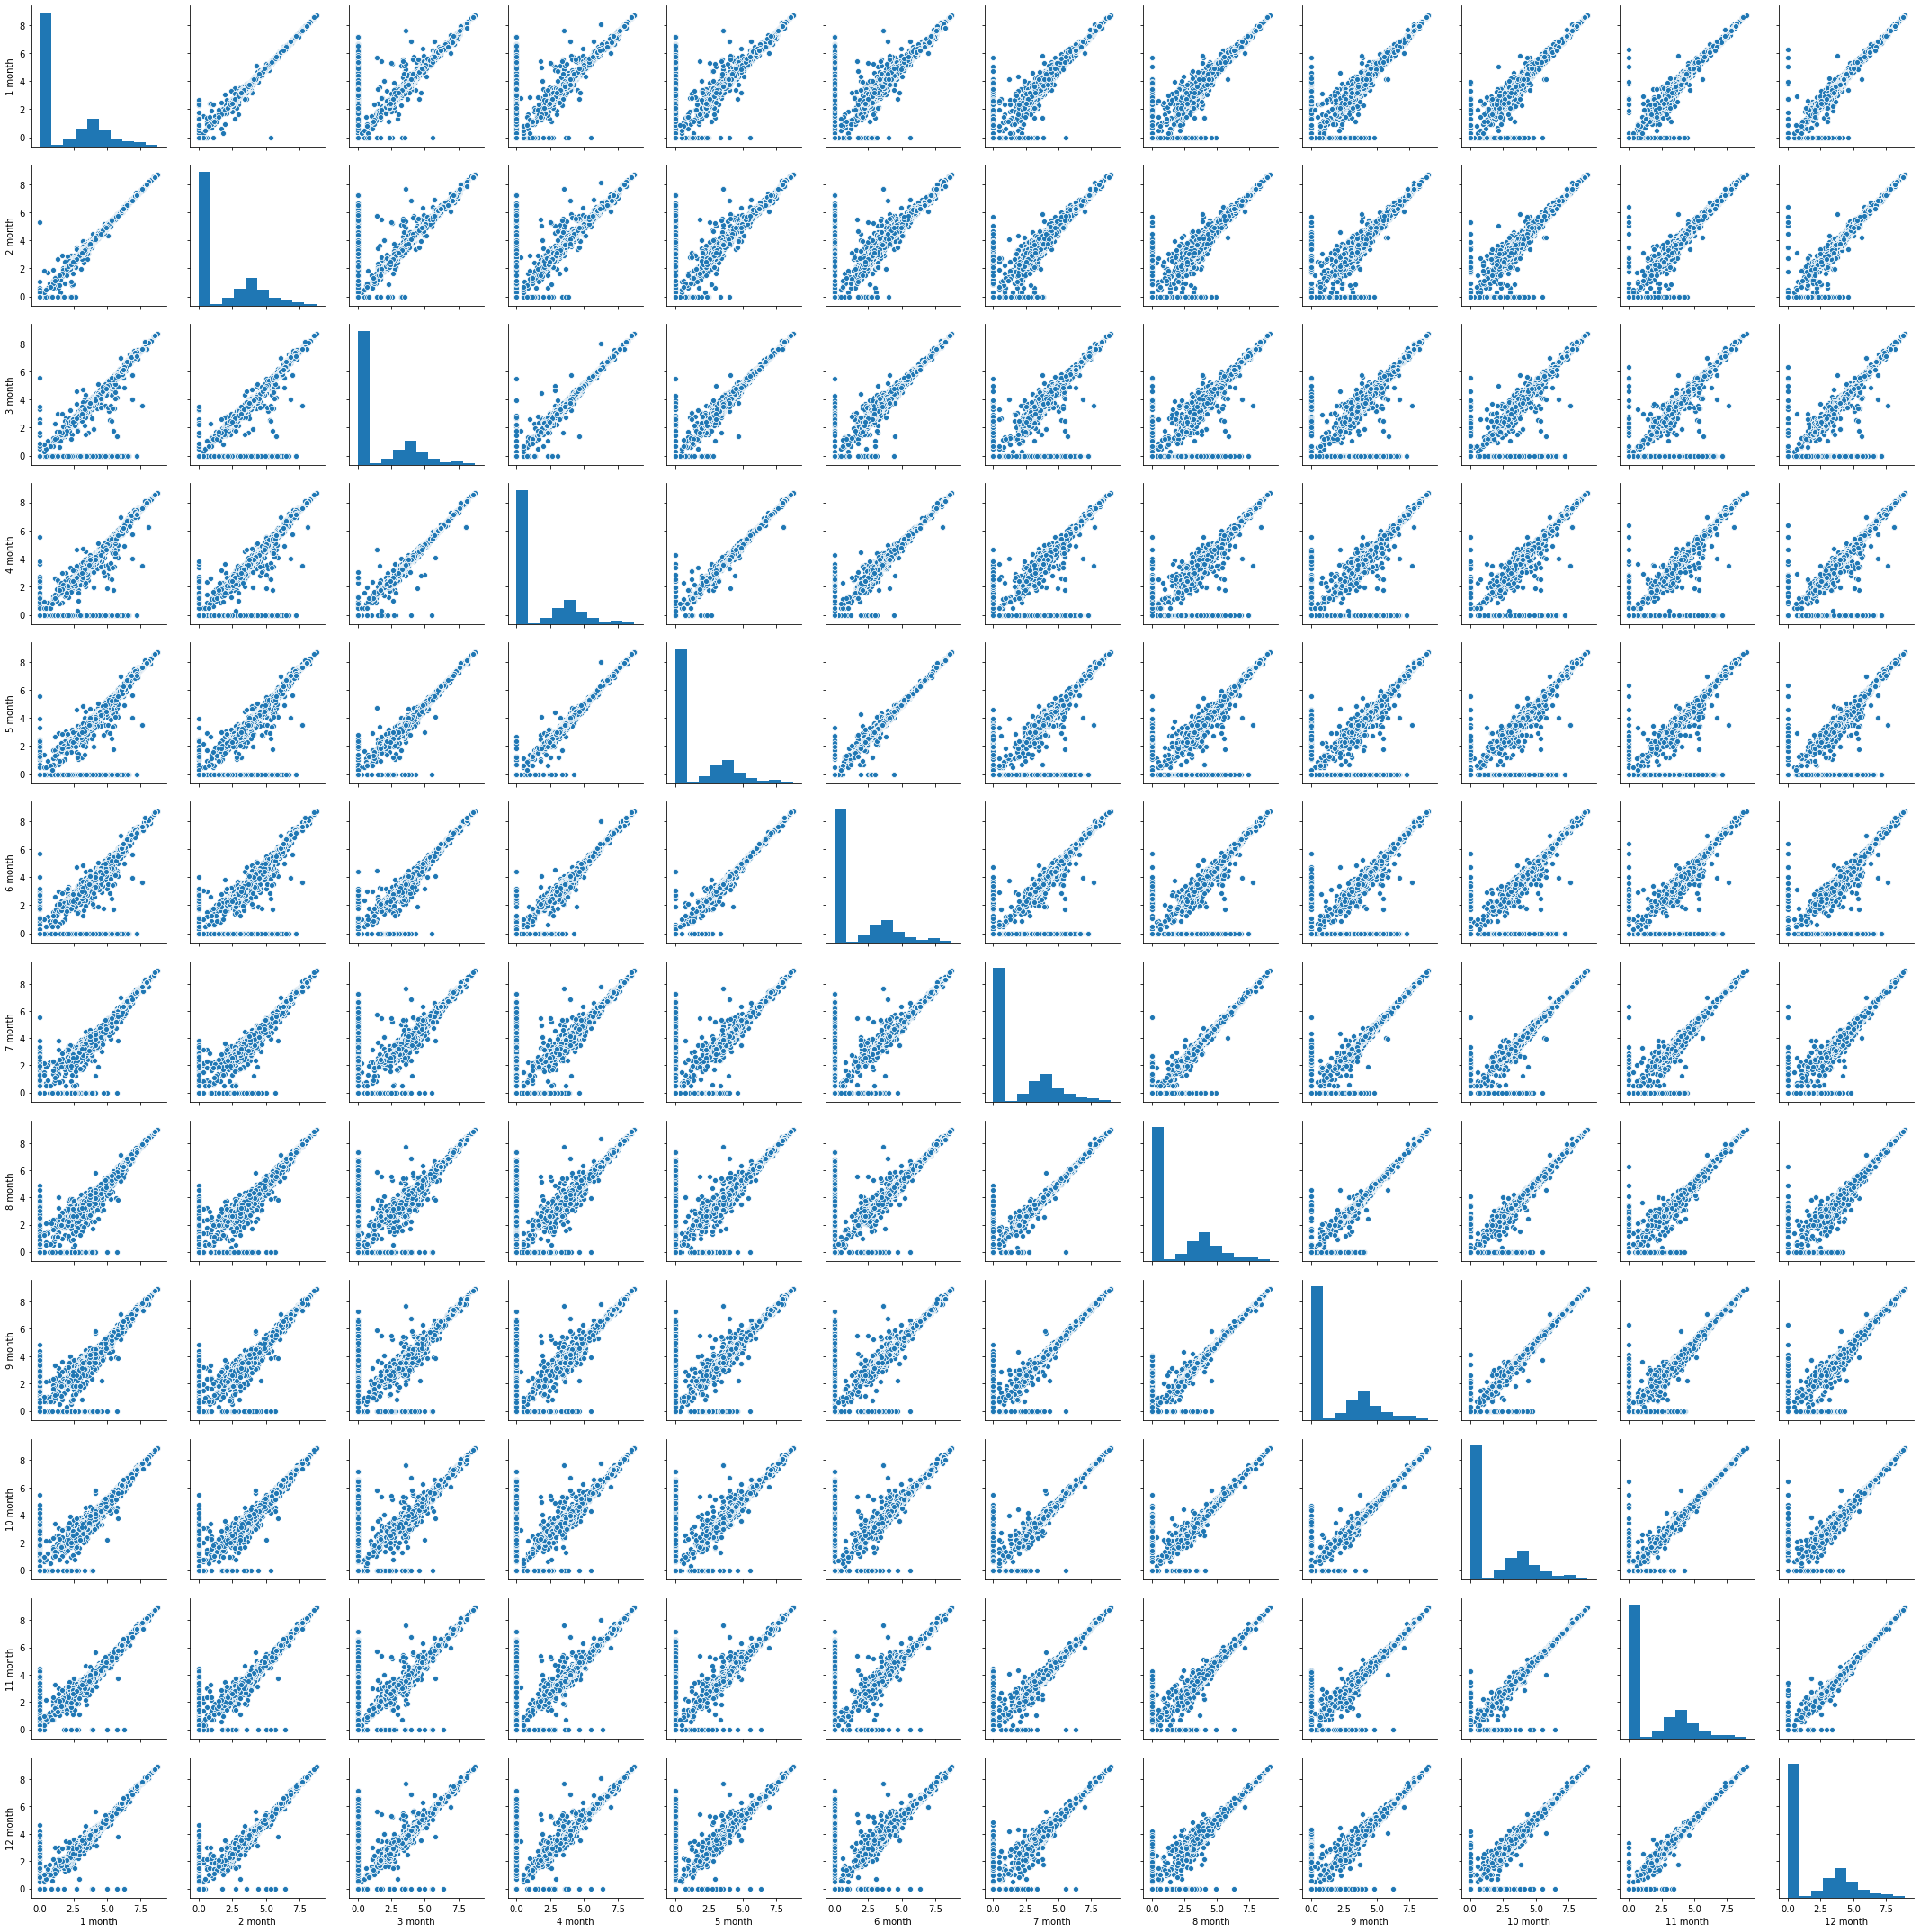

In [11]:
sns.pairplot(df_y.iloc[:,:-2])

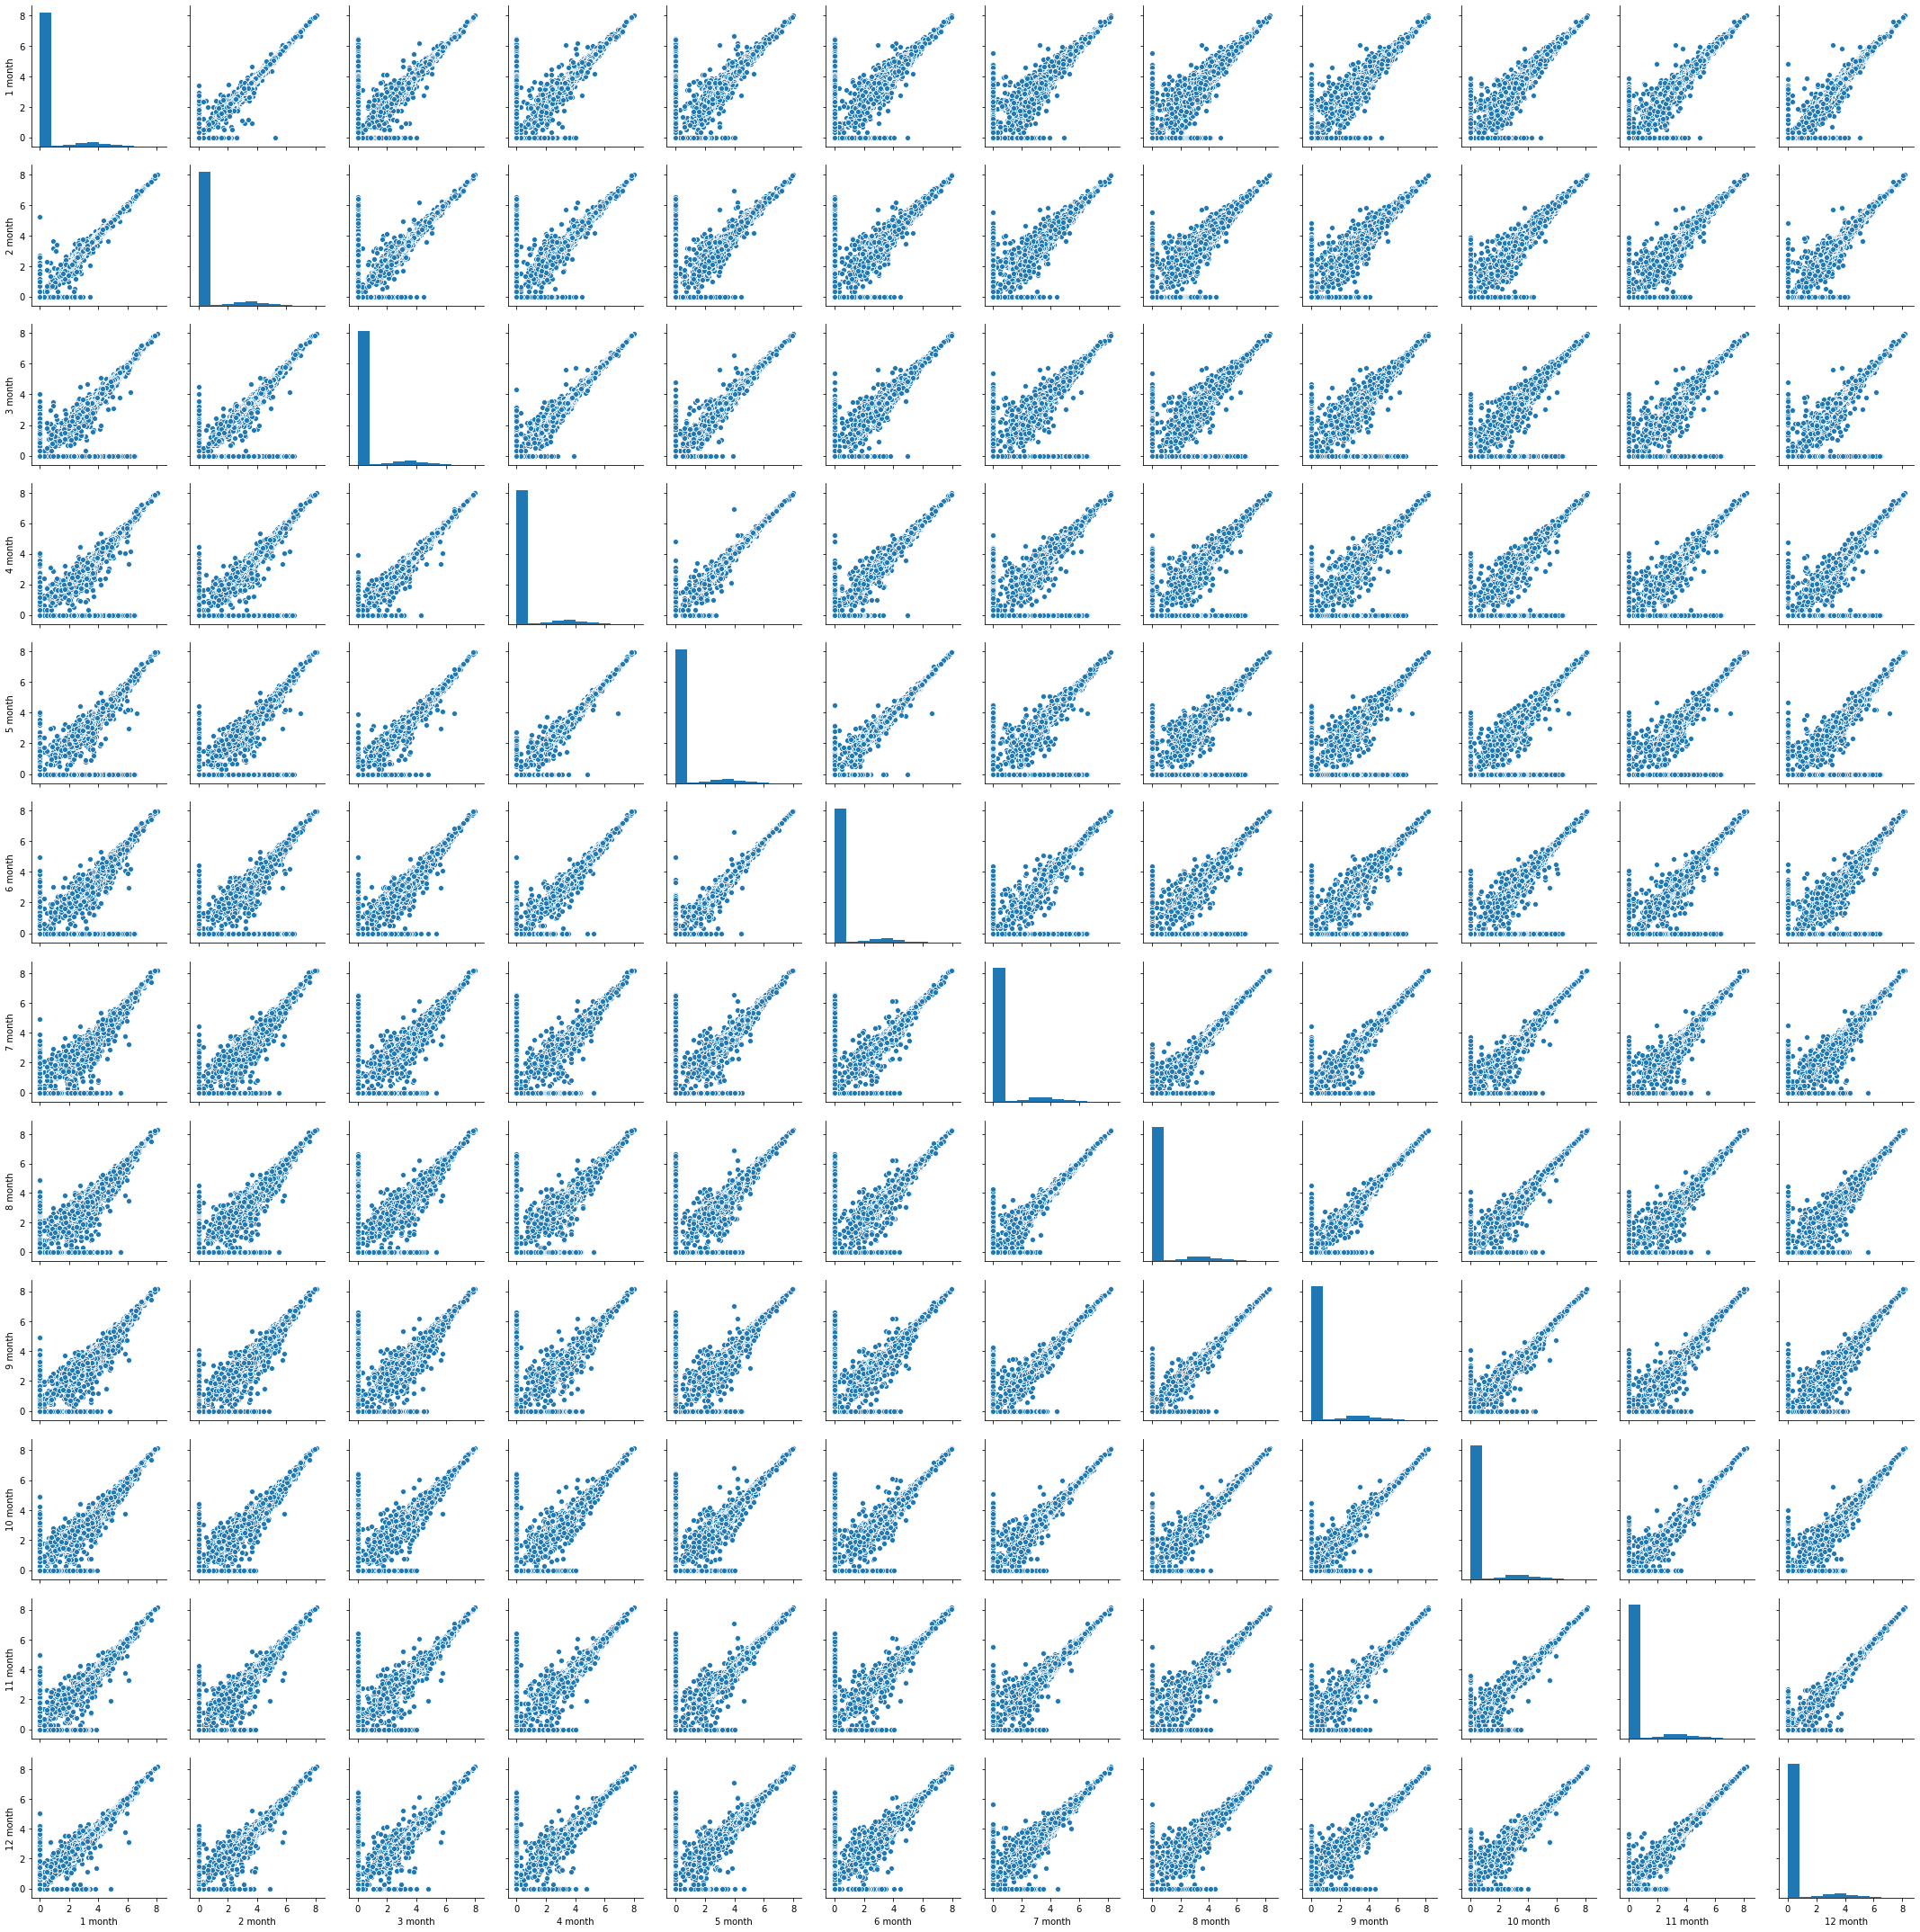

In [12]:
sns.pairplot(df_n.iloc[:,:-2])

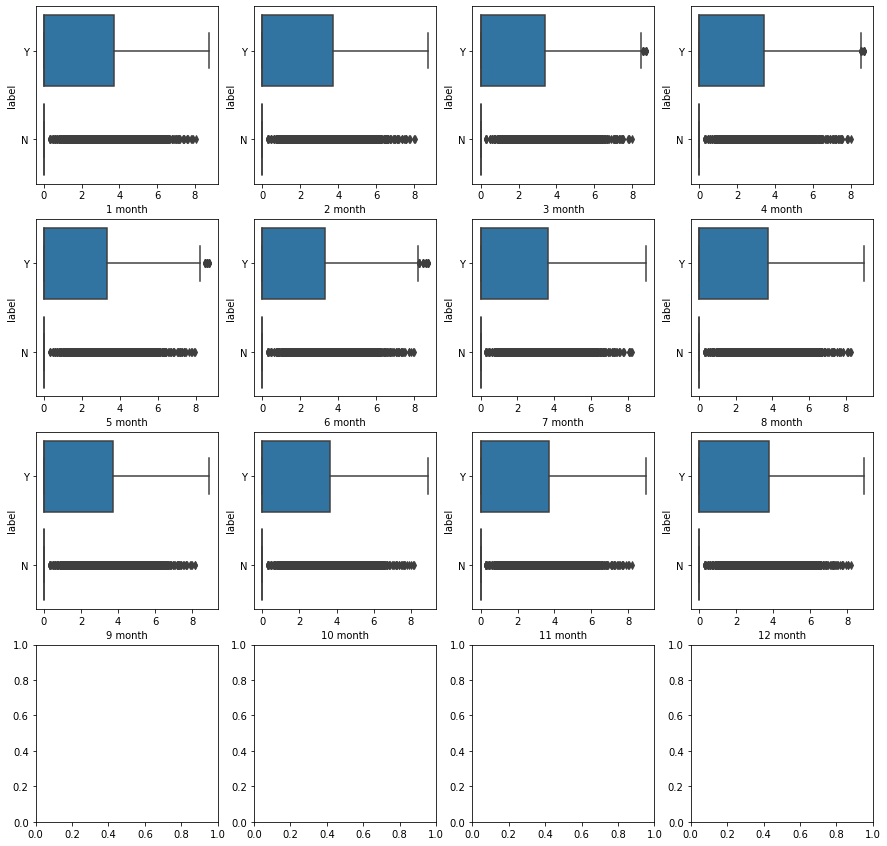

In [20]:
plot_box1(elec_mon_log,'label')

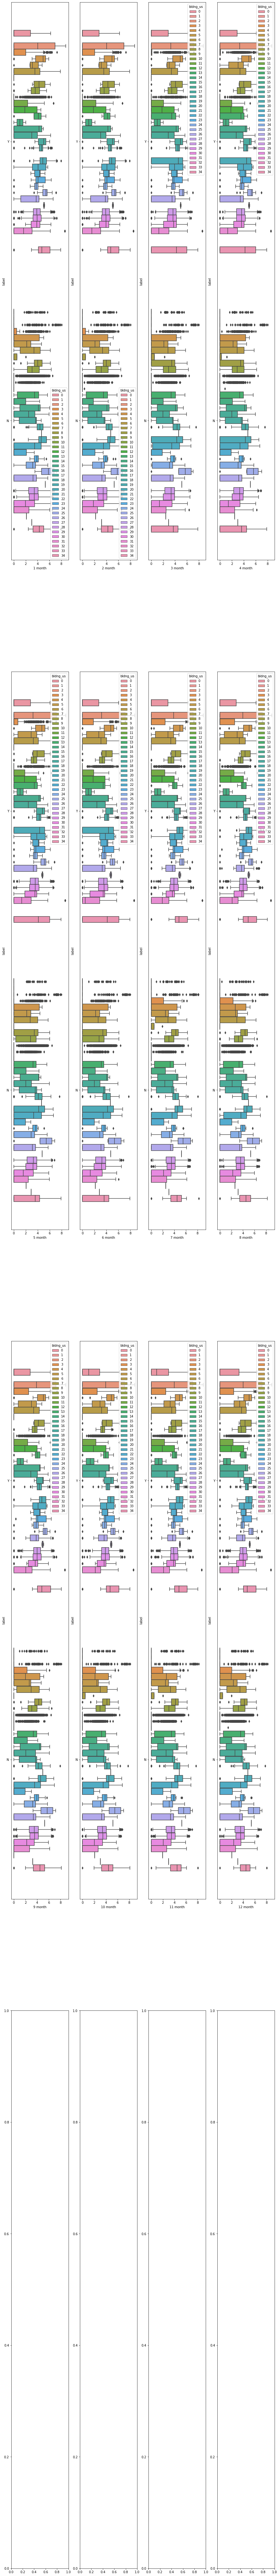

In [21]:
plot_box2(elec_mon_log,'label')

<Figure size 1800x432 with 0 Axes>

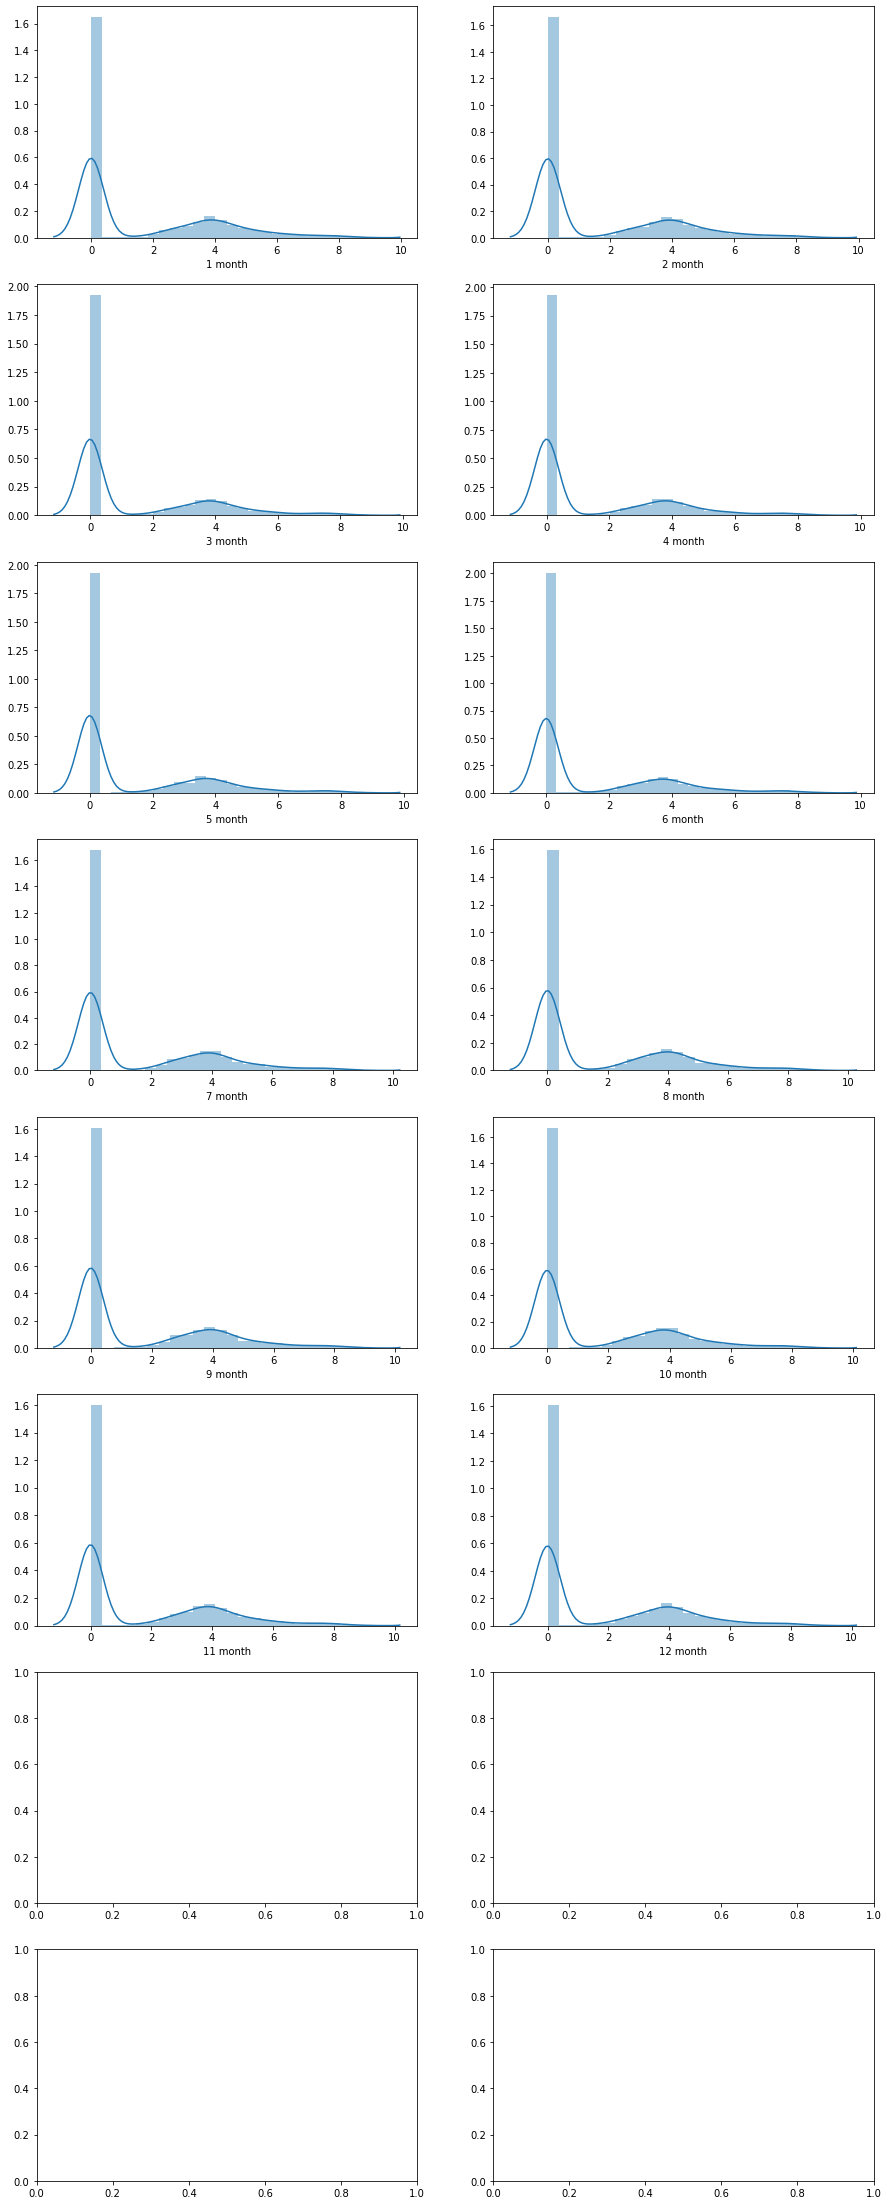

In [22]:
plot_dist(elec_mon_log[elec_mon_log['label']=='Y'])

<Figure size 1800x432 with 0 Axes>

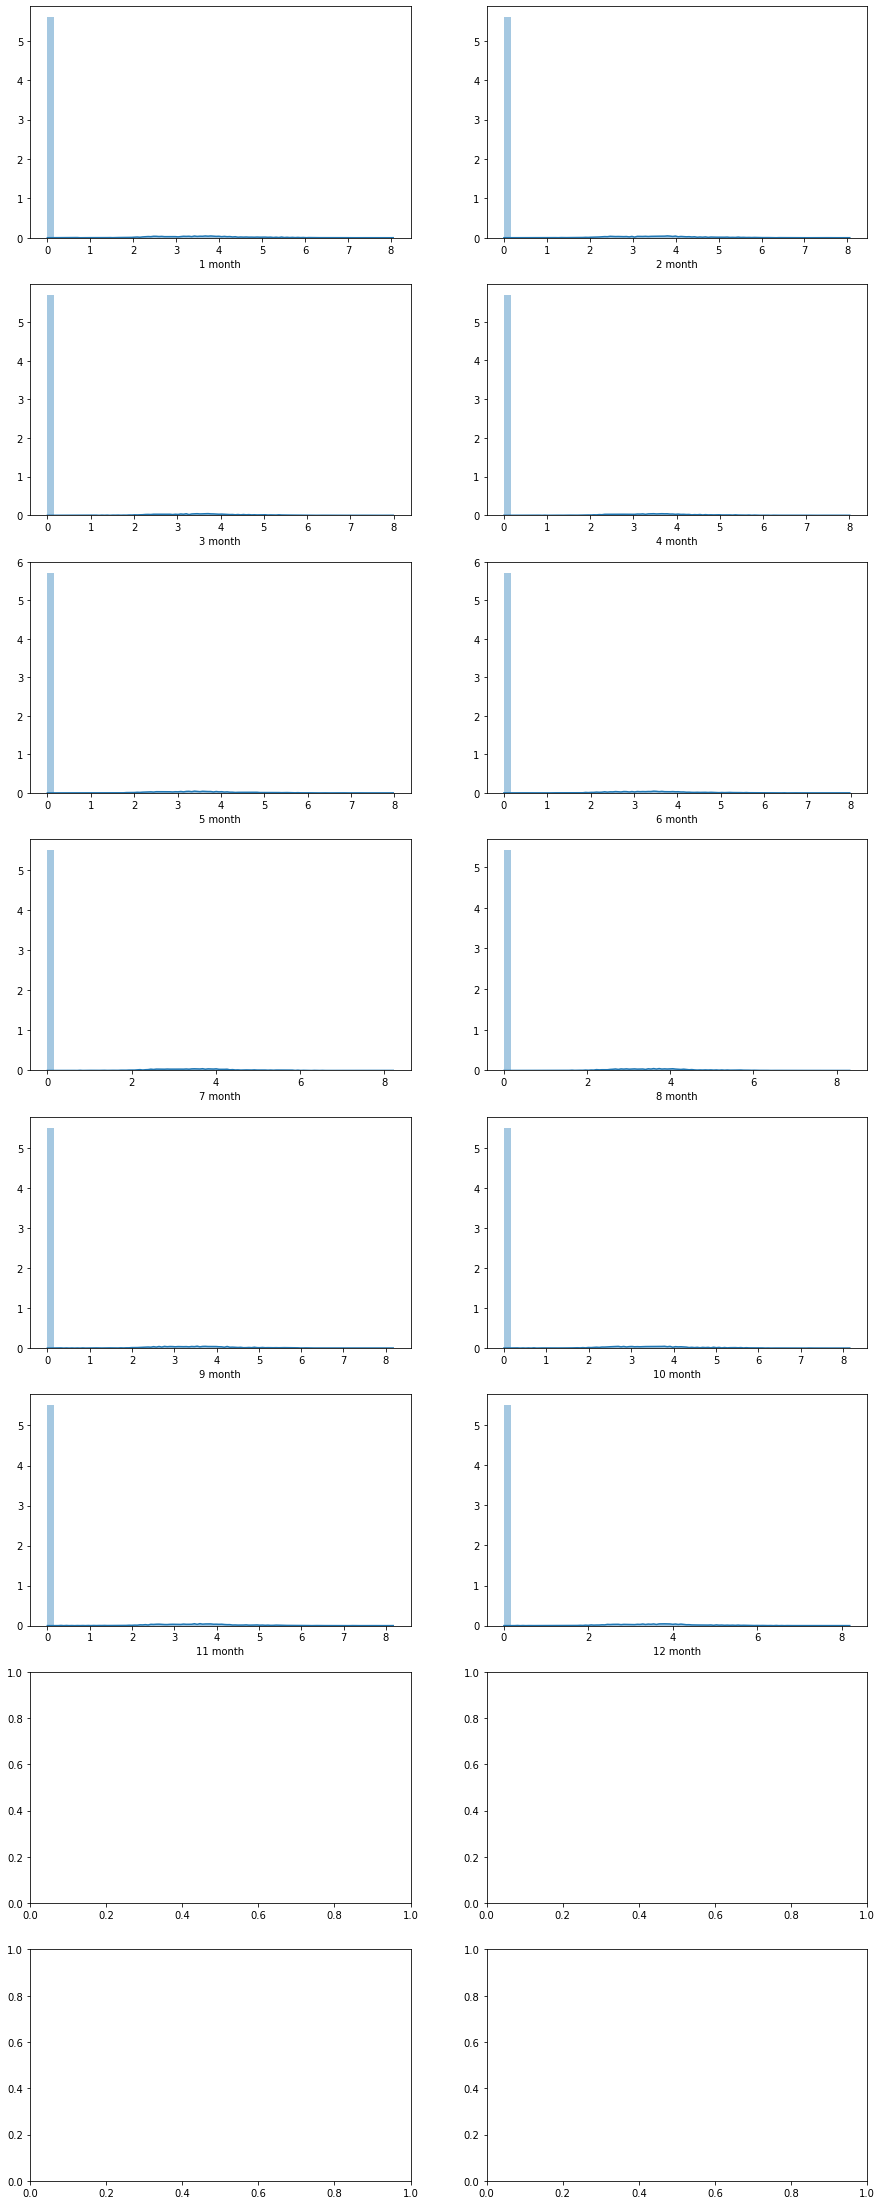

In [23]:
plot_dist(elec_mon_log[elec_mon_log['label']=='N'])

In [15]:
X_train = elec_mon_log.iloc[:,:-2]
Y_train = elec_mon_log.iloc[:,-1].apply(lambda x: 0 if x=='N' else 1)

X_vali = elec_mon_log_vali.iloc[:,:-2]
Y_vali = elec_mon_log_vali.iloc[:,-1].apply(lambda x: 0 if x=='N' else 1)
# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_vali, Y_vali)]
lgbm_wrapper.fit(X_train, Y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=False)
preds = lgbm_wrapper.predict(X_vali)
get_clf_eval(Y_vali,preds)

오차 행렬
[[5592   34]
 [1090  182]]
정확도: 0.8371, 정밀도: 0.8426, 재현율: 0.1431,    F1: 0.2446, AUC:0.5685
